Jason Zhang
HW4 problem 2

In [29]:
from torchvision.datasets import FashionMNIST as FM
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import csv
import time
import torch.nn as nn
fmnist_train = FM("./", train=True, download=True)
fmnist_test = FM("./", train=False, download=True)
train_images = fmnist_train.train_data.numpy().astype(np.float)
train_labels = fmnist_train.train_labels.numpy().astype(np.int)
test_images = fmnist_test.test_data.numpy().astype(np.float)
test_labels = fmnist_test.test_labels.numpy().astype(np.int)

In [30]:
size = train_images.shape[1] * train_images.shape[2]

train_data = train_images.reshape(train_images.shape[0], size)
train_data = (train_data - train_data.mean()) / train_data.std() # Z score normalization
train_data = torch.from_numpy(train_data).float()
train_labels = torch.from_numpy(train_labels)

test_data = test_images.reshape(test_images.shape[0], size)
test_data = (test_data - test_data.mean()) / test_data.std() # Z score normalization
test_data = torch.from_numpy(test_data).float()
test_labels = torch.from_numpy(test_labels)

# Get a validation set from the training set in order to check that the model is not overfitting 
train_split = train_data[0:45000,:]
train_split_labels = train_labels[0:45000]
val_split = train_data[45000:,:]
val_split_labels = train_labels[45000:]

#

# Total number of possible outputs
NUM_CLASSES = 10

# 2A

In [31]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride = 1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride = 1)
        self.fc1 = nn.Linear(32*4*4, 64)
        self.fc2 = nn.Linear(64, 10)
        
    def forward(self, x):
        height = 28
        width = 28
        x = x.view(-1, height, width).unsqueeze(1)
        x = self.conv1(x)
        x = F.relu(x);
        x = F.max_pool2d(x, kernel_size = 3, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        n, c, h, w = x.size()
        x = x.view(-1, c*h*w)
        x = F.relu(self.fc1(x))
        sm = nn.Softmax(dim = 1)
        x = sm(self.fc2(x))
        return x

In [32]:
def train(model, optimizer, batch_size):
    model.train()
    i = np.random.choice(train_split.shape[0], size=batch_size, replace=False) #Choose a random number of samples for the batch
    i = torch.from_numpy(i).long()
    x = autograd.Variable(train_split[i, :])
    y = autograd.Variable(train_split_labels[i]).long()
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    return loss.data

In [33]:
# Check the accuracy with part of the training set to make sure that the model is not overfitting, this part of training set is
# only used for validation
def validate_accuracy(model):
    x = autograd.Variable(val_split)
    y = autograd.Variable(val_split_labels)
    total_samples = val_split.shape[0]
    output = model(x)
    y_hat = np.zeros(total_samples)
    for i in range(total_samples):
        y_hat[i] = torch.max(output[i,:].data, 0)[1]
    return accuracy(y_hat, y.data.numpy())

# computes accuracy of the model with the true labels
def accuracy(y, y_hat):
    count = 0
    num = y.shape[0]
    for i in range(num):
        if y[i] == y_hat[i]:
            count += 1
    return count/num

# Plot training, validation, and loss
def plot(acc, loss):
    plt.figure(300)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')   
    plt.plot(acc, 'b')
    plt.figure(400)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')   
    plt.plot(loss, 'b')
    plt.show()

# begins training with a given model
def runModel(model, batch_size, epochs, optimizer):
    acc, loss = [], []
    for i in range(epochs):
        loss.append(train(model, optimizer, batch_size))
        if i % 100 == 0:
            acc.append(validate_accuracy(model))
            print("Epoch: {0}, Accuracy: {1:.2f}% Loss: {2:.2f}".format(i, acc[-1]*100, loss[-1]))
    plot(acc, loss)

# Function that will predict on the test set    
def predict(model):
    x = autograd.Variable(test_data)
    y = autograd.Variable(test_labels)
    y_hat_ = model(x)
    total_data = test_data.shape[0]
    y_hat = np.zeros(total_data)
    for i in range(total_data):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1]
    return accuracy(y_hat, y.data.numpy())

Epoch: 0, Accuracy: 10.63% Loss: 2.31
Epoch: 100, Accuracy: 57.70% Loss: 1.92
Epoch: 200, Accuracy: 65.39% Loss: 1.77
Epoch: 300, Accuracy: 74.68% Loss: 1.76
Epoch: 400, Accuracy: 75.18% Loss: 1.84
Epoch: 500, Accuracy: 76.13% Loss: 1.71
Epoch: 600, Accuracy: 77.03% Loss: 1.70
Epoch: 700, Accuracy: 78.46% Loss: 1.70
Epoch: 800, Accuracy: 79.21% Loss: 1.64
Epoch: 900, Accuracy: 79.08% Loss: 1.53
Epoch: 1000, Accuracy: 79.56% Loss: 1.71
Epoch: 1100, Accuracy: 80.15% Loss: 1.60
Epoch: 1200, Accuracy: 80.10% Loss: 1.61
Epoch: 1300, Accuracy: 81.19% Loss: 1.56
Epoch: 1400, Accuracy: 81.00% Loss: 1.60
Epoch: 1500, Accuracy: 79.51% Loss: 1.68
Epoch: 1600, Accuracy: 81.85% Loss: 1.68
Epoch: 1700, Accuracy: 80.71% Loss: 1.58
Epoch: 1800, Accuracy: 80.33% Loss: 1.57
Epoch: 1900, Accuracy: 82.06% Loss: 1.69
Epoch: 2000, Accuracy: 82.35% Loss: 1.62
Epoch: 2100, Accuracy: 83.47% Loss: 1.69
Epoch: 2200, Accuracy: 82.39% Loss: 1.60
Epoch: 2300, Accuracy: 83.25% Loss: 1.73
Epoch: 2400, Accuracy: 83.28

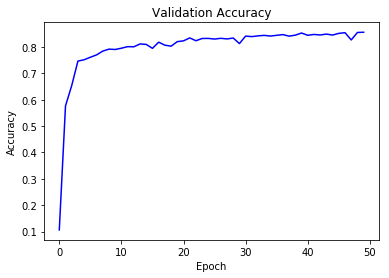

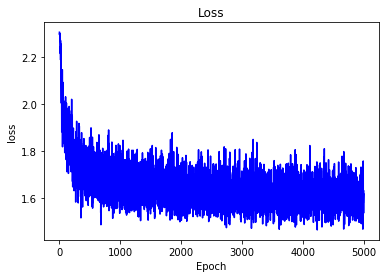

In [34]:
model = MyCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
batch_size = 32
steps = 5000 #epochs
runModel(model, batch_size, steps, optimizer)

In [37]:
acc = predict(model)
print('Accuracy: {0:.2f}%'.format(acc*100))

Accuracy: 85.32%


# 2D

In [157]:
class ImprovedCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=5, padding=2)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(32*7*7, 10)
        self.dropout = nn.Dropout(0.2)
        self.batchN = nn.BatchNorm2d(16)
        self.batchN2 = nn.BatchNorm2d(32)
        
    def forward(self, x):
        height = 28
        width = 28
        x = x.view(-1, height, width).unsqueeze(1)
        x = self.conv1(x)
        x = F.relu(x);
        x = self.batchN(x)
        x = F.max_pool2d(x, kernel_size = 2, stride=2)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchN2(x)
        x = F.max_pool2d(x, kernel_size = 2, stride=2)
        n, c, h, w = x.size()
        x = x.view(-1, c*h*w)
        sm = nn.Softmax(dim = 1)
        x = sm(self.fc1(x))
        return x

Epoch: 0, Accuracy: 26.31% Loss: 2.32
Epoch: 100, Accuracy: 79.19% Loss: 1.68
Epoch: 200, Accuracy: 83.19% Loss: 1.63
Epoch: 300, Accuracy: 85.36% Loss: 1.59
Epoch: 400, Accuracy: 85.64% Loss: 1.65
Epoch: 500, Accuracy: 85.92% Loss: 1.62
Epoch: 600, Accuracy: 86.70% Loss: 1.62
Epoch: 700, Accuracy: 87.07% Loss: 1.59
Epoch: 800, Accuracy: 87.53% Loss: 1.53
Epoch: 900, Accuracy: 87.93% Loss: 1.52
Epoch: 1000, Accuracy: 88.08% Loss: 1.59
Epoch: 1100, Accuracy: 88.26% Loss: 1.64
Epoch: 1200, Accuracy: 87.91% Loss: 1.60
Epoch: 1300, Accuracy: 88.04% Loss: 1.55
Epoch: 1400, Accuracy: 87.45% Loss: 1.53
Epoch: 1500, Accuracy: 88.33% Loss: 1.59
Epoch: 1600, Accuracy: 88.43% Loss: 1.55
Epoch: 1700, Accuracy: 87.85% Loss: 1.59
Epoch: 1800, Accuracy: 88.72% Loss: 1.51
Epoch: 1900, Accuracy: 88.33% Loss: 1.58
Epoch: 2000, Accuracy: 88.33% Loss: 1.55
Epoch: 2100, Accuracy: 88.99% Loss: 1.54
Epoch: 2200, Accuracy: 88.97% Loss: 1.50
Epoch: 2300, Accuracy: 89.07% Loss: 1.55
Epoch: 2400, Accuracy: 88.97

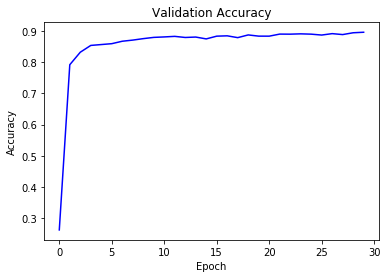

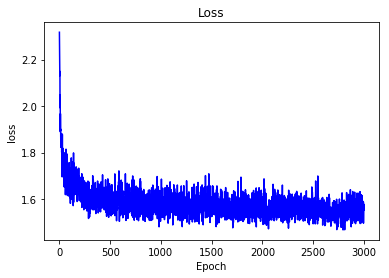

In [161]:
modelImproved = ImprovedCNN()
optimizerAdam = torch.optim.Adam(modelImproved.parameters(), lr=0.001)
runModel(modelImproved, 64, 3000, optimizerAdam)

In [163]:
acc = predict(modelImproved)
print("Accuracy: {0:.2f}%".format(acc*100))

Accuracy: 88.68%
